datetime열에 주어지는 매 시점부터 총 14일(14×24 = 336시간) 분량의 적산차 변화를 예측

In [172]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D

In [173]:
train = pd.read_csv("./data_city/data_tr_city.csv")
test = pd.read_csv("./data_city/data_ts_city.csv")
submit = pd.read_csv("./data_city/sample_city.csv")

In [98]:
# train['datetime'] = pd.to_datetime(train['datetime'])

# train['Year'] = train['datetime'].dt.year
# train['Month'] = train['datetime'].dt.month
# train['Day'] = train['datetime'].dt.day
# train['Dayofweek'] = train['datetime'].dt.dayofweek

# train['구미 혁신도시배수지 유출유량 적산차'] = train['구미 혁신도시배수지 유출유량 적산차'].fillna(train['구미 혁신도시배수지 유출유량 적산차'].mean())
# train.describe()
# train.isna().sum()
# plt.figure(figsize=(10,5))
# plt.plot(train['구미 혁신도시배수지 유출유량 적산차'])
# plt.show()

In [175]:
train = train.fillna(method='bfill')

In [177]:
def dataset(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    labels = []
    
    start_idx = start_idx+history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size
    
    for i in range(start_idx, end_idx):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [180]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std
train['구미 혁신도시배수지 유출유량 적산차'] = normalize(train['구미 혁신도시배수지 유출유량 적산차'], train_split)

array([<AxesSubplot:>], dtype=object)

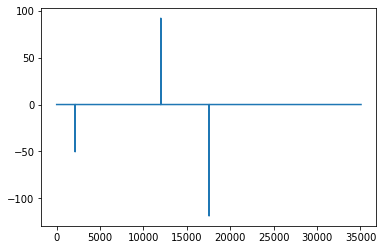

In [181]:
data = train['구미 혁신도시배수지 유출유량 적산차']
data.plot(subplots=True)

In [182]:
data = data.values

In [184]:
split_fraction = 0.715
train_split = int(split_fraction * int(train.shape[0]))

x_train, y_train = dataset(data, 0, train_split, 3360, 336)
x_val, y_val = dataset(data, train_split, 0, 3360, 336)

In [201]:
print(f'x_train.shape: {x_train.shape}')
print(f'y_train.shape: {y_train.shape}')

x_train.shape: (21710, 3360, 1)
y_train.shape: (21710,)


In [189]:
print('Single window of past history')
print(x_train[0])
print('\n Target temperature to predict')
print(y_train[0])

Single window of past history
[[0.00129257]
 [0.00322054]
 [0.00109783]
 ...
 [0.00246104]
 [0.00485639]
 [0.00251946]]

 Target temperature to predict
0.002577883216478743


In [190]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

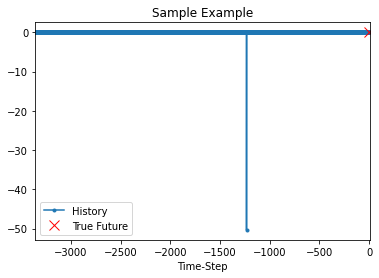

In [191]:
show_plot([x_train[0], y_train[0]], 0, 'Sample Example').show()


In [206]:
inputs = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
lstm_out = keras.layers.LSTM(128)(inputs)
outputs = keras.layers.Dense(336)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mae", metrics = ['mae'])
model.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 3360, 1)]         0         
                                                                 
 lstm_28 (LSTM)              (None, 128)               66560     
                                                                 
 dense_26 (Dense)            (None, 336)               43344     
                                                                 
Total params: 109,904
Trainable params: 109,904
Non-trainable params: 0
_________________________________________________________________


In [207]:
model.fit(
x_train, y_train,
epochs=1,
validation_data=(x_val, y_val)
)

679/679 [==============================] - 93s 135ms/step - loss: 0.0122 - mae: 0.0122


In [ ]:
# split_fraction = 0.715
# train_split = int(split_fraction * int(train.shape[0]))
# step = 6

# past = 3360
# future = 336
# learning_rate = 0.001
# batch_size = 256
# epochs = 10


# def normalize(data, train_split):
#     data_mean = data[:train_split].mean(axis=0)
#     data_std = data[:train_split].std(axis=0)
#     return (data - data_mean) / data_std
# train['구미 혁신도시배수지 유출유량 적산차'] = normalize(train['구미 혁신도시배수지 유출유량 적산차'], train_split)
# start = past + future
# end = start + train_split
# sequence_length = int(past / step)
# train_data = train.loc[0 : train_split-1]
# val_data = train.loc[train_split:]
# x_train = train['구미 혁신도시배수지 유출유량 적산차'].values
# y_train = train['구미 혁신도시배수지 유출유량 적산차'].iloc[start:end].values

# x_train = x_train.reshape(-1, 1)
# y_train = y_train.reshape(-1, 1)
# from tensorflow import keras
# dataset_train = keras.preprocessing.timeseries_dataset_from_array(
#     x_train,
#     y_train,
#     sequence_length=sequence_length,
#     sampling_rate=step,
#     batch_size=batch_size,
# )
# dataset_train
# x_end = len(val_data) - past - future

# label_start = train_split + past + future

# x_val = val_data['구미 혁신도시배수지 유출유량 적산차'].values
# y_val = val_data['구미 혁신도시배수지 유출유량 적산차'].iloc[label_start:].values
# x_val = x_val.reshape(-1, 1)
# y_val = y_val.reshape(-1, 1)

# dataset_val = keras.preprocessing.timeseries_dataset_from_array(
#     x_val,
#     y_val,
#     sequence_length=sequence_length,
#     sampling_rate=step,
#     batch_size=batch_size,
# )
# for batch in dataset_train.take(1):
#     inputs, targets = batch

# print("Input shape:", inputs.numpy().shape)
# print("Target shape:", targets.numpy().shape)